In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/ТМСС

/content/drive/MyDrive/ТМСС


In [ ]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from torchvision import models
from torch import nn
import torch.nn.functional as F
import time
import copy
import seaborn as sns
from PIL import Image
from sklearn.metrics import roc_curve, RocCurveDisplay,auc
import cv2
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

загрузка данных

In [ ]:
train_data = pd.read_csv('./SimpleCube++/auxiliary/train_properties.csv')
test_data = pd.read_csv('./SimpleCube++/auxiliary/test_properties.csv')

выброс неразмеченных даннных

In [ ]:
train_data.drop( train_data[(train_data['place'] == 'unknown') | (train_data['illumination'] == 'unknown')].index, axis=0,inplace=True)
test_data.drop(test_data[(test_data['place'] == 'unknown') | (test_data['illumination'] == 'unknown')].index, axis=0,inplace=True)

подключение собственной разметки

In [ ]:
labeled_train = pd.read_csv('labeled_data.csv')
labeled_test = pd.read_csv('labeled_test.csv')

объединение наборов данных

In [ ]:
train_data = pd.concat([train_data, labeled_train])
test_data = pd.concat([test_data, labeled_test])

In [ ]:
train_data = train_data[['image', 'place', 'illumination']]
test_data = test_data[['image', 'place', 'illumination']]

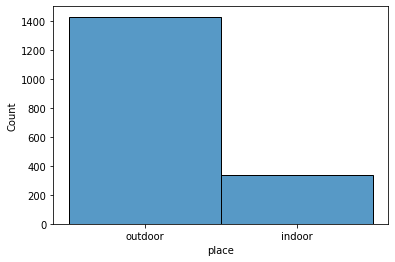

In [ ]:
sns.histplot(train_data['place'])

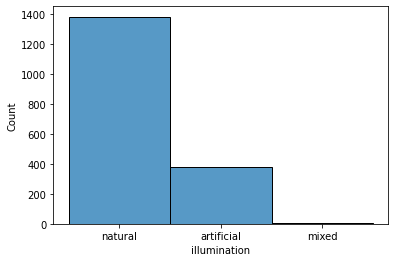

In [ ]:
sns.histplot(train_data['illumination'])

разделение датасета на три подмножества \\
1) outdoor natural \\
2) outdoor arttificial \\
3) indoor artificial \\

In [ ]:
outdoor_natural_train = train_data[(train_data['place'] == 'outdoor') & (train_data['illumination'] == 'natural')]
outdoor_natural_train['label'] = 0
outdoor_natural_test= test_data[(test_data['place'] == 'outdoor') & (test_data['illumination'] == 'natural')]
outdoor_natural_test['label'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
outdoor_artificial_train = train_data[(train_data['place'] == 'outdoor') & (train_data['illumination'] == 'artificial')]
outdoor_artificial_train['label'] = 1
outdoor_artificial_test = test_data[(test_data['place'] == 'outdoor') & (test_data['illumination'] == 'artificial')]
outdoor_artificial_test['label'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
indoor_artificial_train = train_data[(train_data['place'] == 'indoor') & (train_data['illumination'] == 'artificial')]
indoor_artificial_train['label'] = 2
indoor_actificial_test = test_data[(test_data['place'] == 'indoor') & (test_data['illumination'] == 'artificial')]
indoor_actificial_test['label'] = 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
indoor_actificial_test.head()

,image,place,illumination,label
114,00_1150,indoor,artificial,2
184,00_2849,indoor,artificial,2
189,01_7866,indoor,artificial,2
192,02_8085,indoor,artificial,2
193,02_8087,indoor,artificial,2


из-за слишком малого количества экземпляров в классе outdoor artificial, для него будет применения аугментация

In [ ]:
outdoor_artificial_train_aug = outdoor_artificial_train.copy()
outdoor_artificial_train_aug.image = outdoor_artificial_train_aug.image.apply(lambda x: f'{x}/aug0')
for i in range(1,3):
  outdoor_artificial_train_aug_cp = outdoor_artificial_train.copy()
  outdoor_artificial_train_aug_cp.image = outdoor_artificial_train.image.apply(lambda x: f'{x}/aug{i}')
  outdoor_artificial_train_aug = pd.concat([outdoor_artificial_train_aug, outdoor_artificial_train_aug_cp])

In [ ]:
outdoor_artificial_test_aug = outdoor_artificial_test.copy()
outdoor_artificial_test_aug.image = outdoor_artificial_test_aug.image.apply(lambda x: f'{x}/aug0')
for i in range(1,3):
  outdoor_artificial_test_aug_cp = outdoor_artificial_test.copy()
  outdoor_artificial_test_aug_cp.image = outdoor_artificial_test.image.apply(lambda x: f'{x}/aug{i}')
  outdoor_artificial_test_aug = pd.concat([outdoor_artificial_test_aug, outdoor_artificial_test_aug_cp])

In [ ]:
outdoor_artificial_test_aug.shape

(36, 4)

In [ ]:
outdoor_artificial_test_aug.head()

,image,place,illumination,label
47,00_0535/aug0,outdoor,artificial,1
2,00_0125/aug0,outdoor,artificial,1
8,00_0310/aug0,outdoor,artificial,1
14,00_0735/aug0,outdoor,artificial,1
26,00_1075/aug0,outdoor,artificial,1


In [ ]:
outdoor_artificial_train_aug.shape

(288, 4)

In [ ]:
outdoor_artificial_train_aug.head()

,image,place,illumination,label
108,00_0352/aug0,outdoor,artificial,1
719,00_2873/aug0,outdoor,artificial,1
722,00_2886/aug0,outdoor,artificial,1
723,00_2889/aug0,outdoor,artificial,1
726,00_2896/aug0,outdoor,artificial,1


объединение аугментации и исходных данных

In [ ]:
train_set = pd.concat([outdoor_natural_train[['image', 'label']], outdoor_artificial_train[['image', 'label']], indoor_artificial_train[['image', 'label']], outdoor_artificial_train_aug[['image', 'label']]])
test_set = pd.concat([outdoor_natural_test[['image', 'label']], outdoor_artificial_test[['image', 'label']], indoor_actificial_test[['image', 'label']], outdoor_artificial_test_aug[['image', 'label']]])

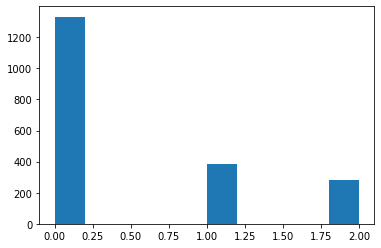

In [ ]:
plt.hist(train_set['label'])
plt.show()

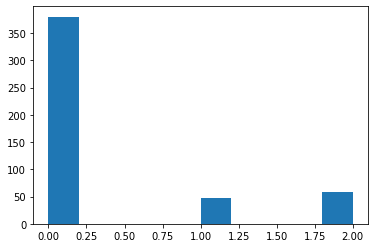

In [ ]:
plt.hist(test_set['label'])
plt.show()

аугментация будет применятся при загрузке данных.
если в названии встретится слово aug, то применится рандомные 2 из 5 функции аугментации

фунциии аугментации

In [ ]:
def fliped_image( img):
    deg = np.random.choice([90, 0], 1)[0]
    return cv2.flip(img, deg)

def contrasted_image( img):
  brightness = 10
  contrast = np.random.randint(40, 100)
  dummy = np.int16(img)
  dummy = dummy * (contrast/127+1) - contrast + brightness
  dummy = np.clip(dummy, 0, 255)
  ctr_img = np.uint8(dummy)
  return ctr_img


def croped_image(img):
  left_corner_x = int(np.random.randint(7, 20, 1) * img.shape[0]/100)
  left_corner_y = int(np.random.randint(7, 20, 1) * img.shape[1]/100)
  right_corner_x = int(img.shape[0] - np.random.randint(7, 20, 1) * img.shape[0]/100)
  right_corner_y = int(img.shape[1] - np.random.randint(7, 20, 1) * img.shape[1]/100)
  croped_img = img[left_corner_x:right_corner_x, left_corner_y: right_corner_y, :]
  return cv2.resize(croped_img, (img.shape[1], img.shape[0]))


def identitied_image( img):
  kernel = np.array([[0,0,0], 
                    [0,1,0],
                    [0,0,0]])
  Identity = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
  return Identity


def blur_image(img):
  kernel2 = np.ones((5, 5), np.float32) / 25
  blur = cv2.filter2D(src=img, ddepth=-1, kernel=kernel2)
  return blur

In [ ]:
img_dir = './SimpleCube++/auxiliary/JPG'
batch_size = 32

In [ ]:
class Data(Dataset):
  def __init__(self, path, data_csv, phase = 'train', size=(224, 224)):
    self.images = data_csv.values.T[0]
    self.label = data_csv.values.T[1]
    self.path = path
    self.phase = phase
    # предобработка данных
    self.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize(size)
    ])
    self.classes = np.unique(self.label)
    # список функции аугментации
    self.augs = [fliped_image, croped_image, contrasted_image, identitied_image, blur_image]
  
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_full_name =f'{self.path}/{self.phase}_{self.images[idx].split("/")[0]}.jpg'

    if 'aug' in self.images[idx]:
      aug1, aug2 = np.random.choice(self.augs, 2)
      img = cv2.imread(image_full_name)
      img = aug1(aug2(img))
    else:
      img = cv2.imread(image_full_name)
    img = self.transform(img)
      
    return img, self.label[idx]

  

In [ ]:
train_dataset = Data(img_dir, train_set, 'train')
test_dataset =  Data(img_dir, test_set, 'test')

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':train_data.shape[0],
    'val':test_data.shape[0]
}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)

In [ ]:
model_vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Softmax()
            )

In [ ]:
model_vgg16.__dict__

{'_backward_hooks': OrderedDict(),
 '_buffers': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('features', Sequential(
                 (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (1): ReLU(inplace=True)
                 (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (3): ReLU(inplace=True)
                 (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
                 (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (6): ReLU(inplace=True)
                 (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (8): ReLU(inplace=True)
                 (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
                 (10): 

In [ ]:
model_vgg16 = model_vgg16.to(device)

In [ ]:
# weits = torch.Tensor([0.1]).to(device)

In [ ]:
# optimizer_ft = optim.Adam(model_vgg16.parameters(), lr=0.001)
optimizer = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_model(model, criterion, optimizer, epoch=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_loss = 5
  best_f1 = 0.0
  best_loss = 1000

  for i in range(epoch):
    for phase in ['train', 'val']:
      losses = []
      if phase == 'train':
        model.train()
      if phase == 'val':
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      whole_preds = []
      whole_targets = []
      whole_probs = []

      for inputs, labels in dataloaders[phase]:
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          inputs = inputs.to(device)
          labels = labels.to(device)
          labels = labels.to(torch.long)

          # target = torch.argmax(labels, dim=1)
          
          probs = model(inputs)

          max_probs, preds = torch.max(probs, 1)
          
          labels_cpu = labels.cpu().detach().numpy()
          loss = criterion(probs,labels)
          loss_for_save = loss.clone().to(cpu).detach().numpy()


          if (phase == 'train'):
              loss.backward()
              optimizer.step()

          losses.append(loss_for_save)

          
        preds_cpu = preds.cpu().detach().numpy()
        running_loss += loss*inputs.size(0)
        target_cpu = labels.cpu().detach().numpy()
        whole_preds = np.concatenate([whole_preds, preds_cpu], axis=None)
        whole_targets = np.concatenate([whole_targets, target_cpu], axis=None)
        whole_probs = np.concatenate([whole_probs, torch.squeeze(probs).to(cpu).detach().numpy()], axis=None)
        # if(batch_f1_score < 0.5):
        #   print(batch_f1_score)

        
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_f1 =  f1_score(whole_targets, whole_preds, average='macro')
      epoch_precision = precision_score(whole_targets, whole_preds, average='macro')
      epoch_recalls = recall_score(whole_targets, whole_preds, average='macro')
      



      plt.plot(losses)
      plt.title(f'learning curve for phase: {phase} for epoch {i}', fontsize=6)
      plt.grid(True)
      plt.show()
      



      print('{} Loss: {:.4f} f1: {:.4f} precision: {:.4f} recall: {:.4f}'.format(
          phase, epoch_loss, epoch_f1, epoch_precision, epoch_recalls))
      print('####################################################')

      # deep copy the model
      if phase == 'val' and epoch_loss < best_loss:
          best_loss = epoch_loss
          best_model_wts = copy.deepcopy(model.state_dict())
          torch.save(model.state_dict(), f'/content/drive/MyDrive/ТМСС/models/CNet_{i}')
      
  torch.save(model.state_dict(), f'/content/drive/MyDrive/ТМСС/models/CNet_final')
  model.load_state_dict(best_model_wts)
  
  return model

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


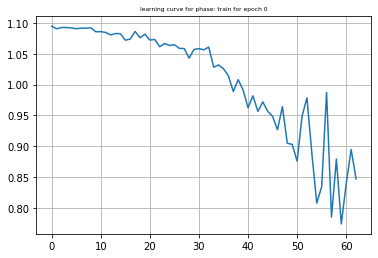

train Loss: 1.1413 f1: 0.2832 precision: 0.3858 recall: 0.3367
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


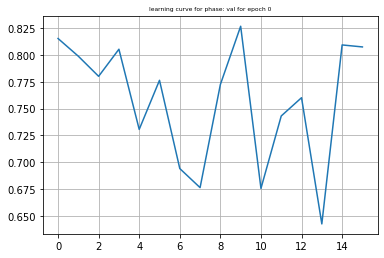

val Loss: 0.7954 f1: 0.2922 precision: 0.2601 recall: 0.3333
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


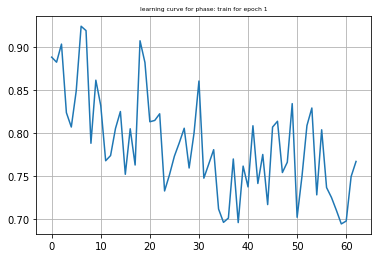

train Loss: 0.8909 f1: 0.4403 precision: 0.5115 recall: 0.4470
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


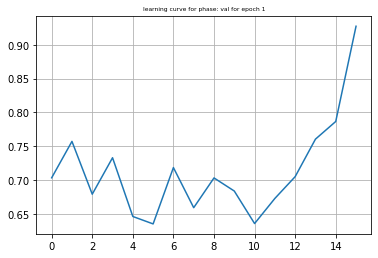

val Loss: 0.7397 f1: 0.5572 precision: 0.4988 recall: 0.6484
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


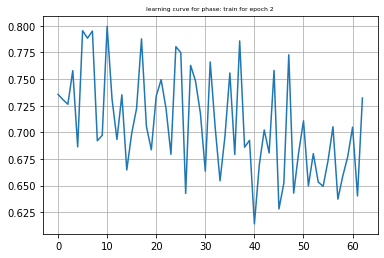

train Loss: 0.8011 f1: 0.6807 precision: 0.7935 recall: 0.6984
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


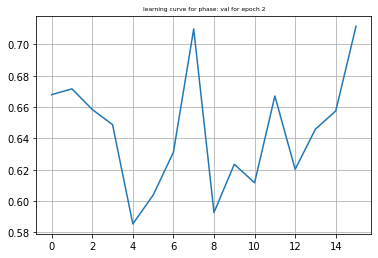

val Loss: 0.6754 f1: 0.8430 precision: 0.8319 recall: 0.8561
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


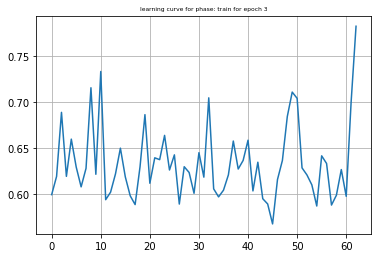

train Loss: 0.7151 f1: 0.8684 precision: 0.8795 recall: 0.8589
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


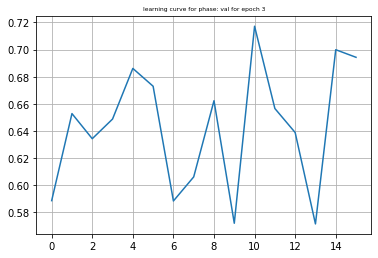

val Loss: 0.6752 f1: 0.8097 precision: 0.8989 recall: 0.7714
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


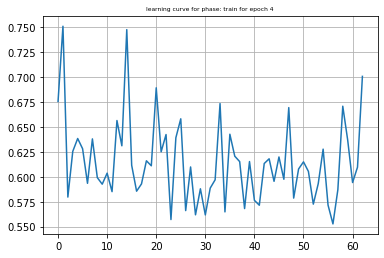

train Loss: 0.6951 f1: 0.8979 precision: 0.9118 recall: 0.8853
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


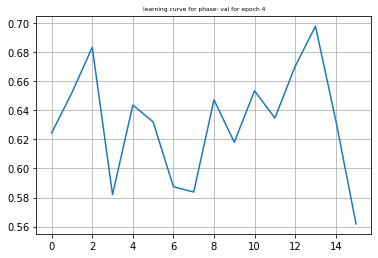

val Loss: 0.6696 f1: 0.8598 precision: 0.8203 recall: 0.9141
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


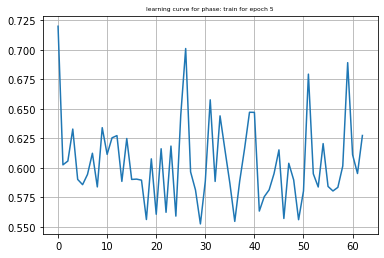

train Loss: 0.6838 f1: 0.9125 precision: 0.9190 recall: 0.9063
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


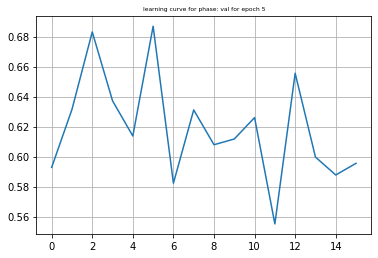

val Loss: 0.6533 f1: 0.8573 precision: 0.9028 recall: 0.8210
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


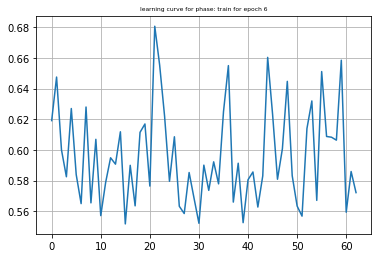

train Loss: 0.6750 f1: 0.9250 precision: 0.9308 recall: 0.9200
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


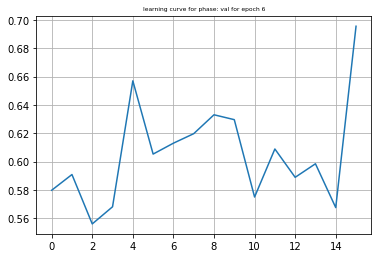

val Loss: 0.6333 f1: 0.9038 precision: 0.9142 recall: 0.9022
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


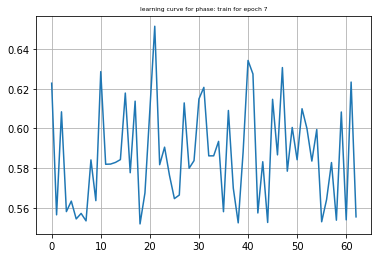

train Loss: 0.6642 f1: 0.9439 precision: 0.9500 recall: 0.9382
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


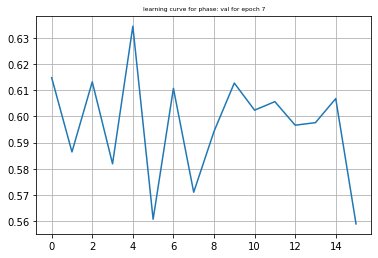

val Loss: 0.6311 f1: 0.9051 precision: 0.9078 recall: 0.9061
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


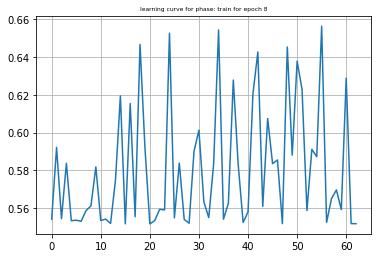

train Loss: 0.6578 f1: 0.9578 precision: 0.9652 recall: 0.9507
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


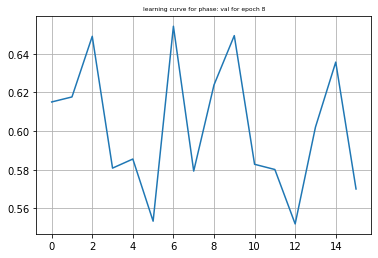

val Loss: 0.6362 f1: 0.9015 precision: 0.8914 recall: 0.9126
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


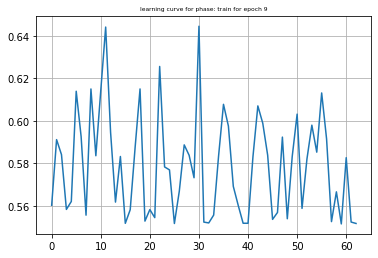

train Loss: 0.6556 f1: 0.9607 precision: 0.9664 recall: 0.9552
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


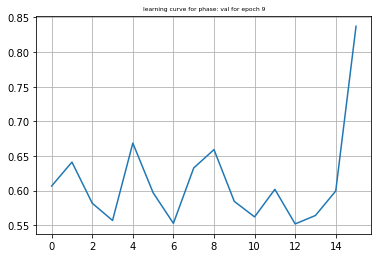

val Loss: 0.6333 f1: 0.9098 precision: 0.9430 recall: 0.8840
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


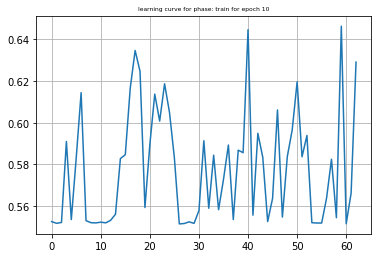

train Loss: 0.6538 f1: 0.9625 precision: 0.9687 recall: 0.9566
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


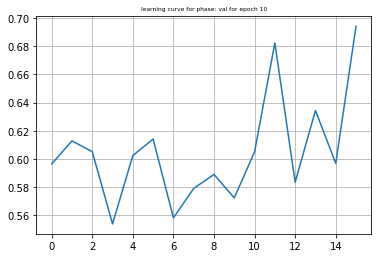

val Loss: 0.6328 f1: 0.9024 precision: 0.8944 recall: 0.9108
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


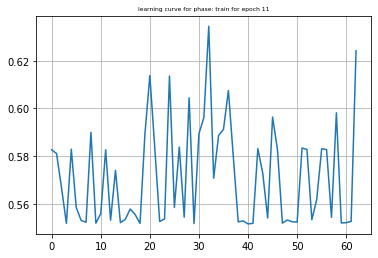

train Loss: 0.6466 f1: 0.9716 precision: 0.9751 recall: 0.9682
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


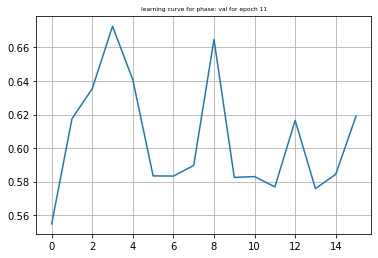

val Loss: 0.6370 f1: 0.8922 precision: 0.9274 recall: 0.8670
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


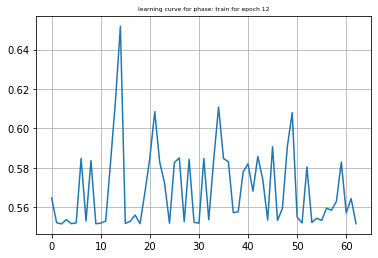

train Loss: 0.6450 f1: 0.9740 precision: 0.9776 recall: 0.9706
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


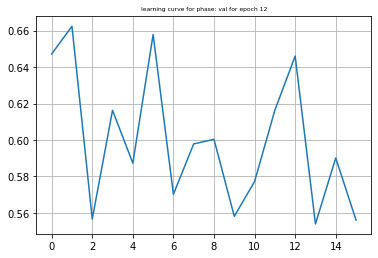

val Loss: 0.6344 f1: 0.8983 precision: 0.9090 recall: 0.8883
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


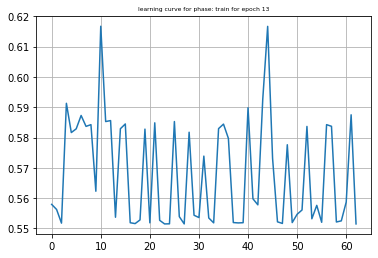

train Loss: 0.6434 f1: 0.9754 precision: 0.9790 recall: 0.9720
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


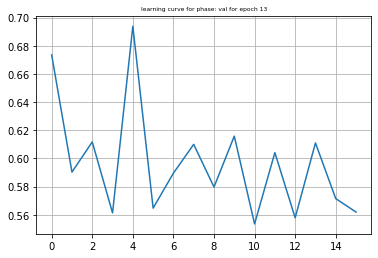

val Loss: 0.6311 f1: 0.8946 precision: 0.9061 recall: 0.8892
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


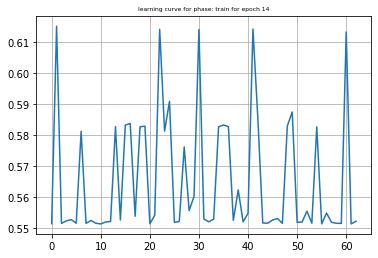

train Loss: 0.6403 f1: 0.9806 precision: 0.9831 recall: 0.9782
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


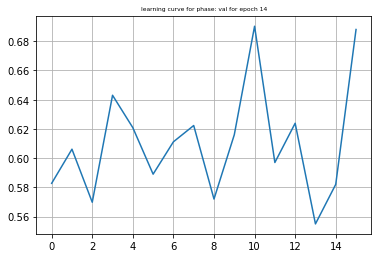

val Loss: 0.6394 f1: 0.8915 precision: 0.8800 recall: 0.9100
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


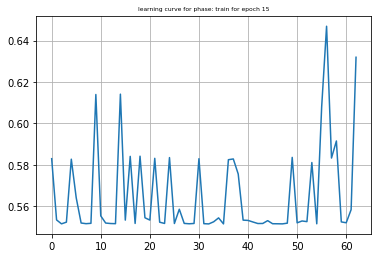

train Loss: 0.6390 f1: 0.9819 precision: 0.9852 recall: 0.9787
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


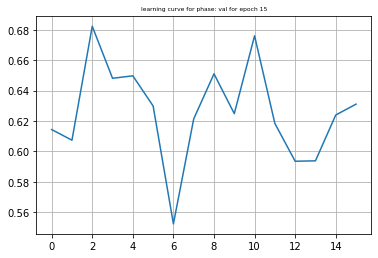

val Loss: 0.6597 f1: 0.8677 precision: 0.8566 recall: 0.8960
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


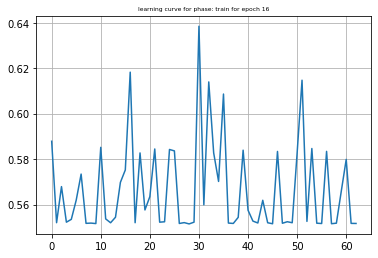

train Loss: 0.6415 f1: 0.9800 precision: 0.9828 recall: 0.9773
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


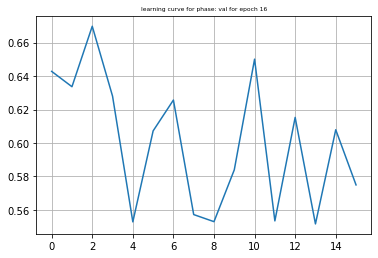

val Loss: 0.6344 f1: 0.8971 precision: 0.8991 recall: 0.8952
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


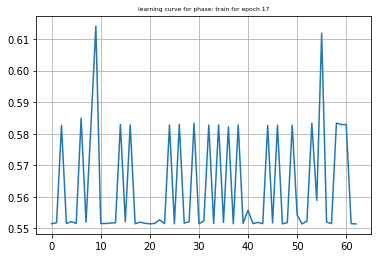

train Loss: 0.6379 f1: 0.9827 precision: 0.9848 recall: 0.9806
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


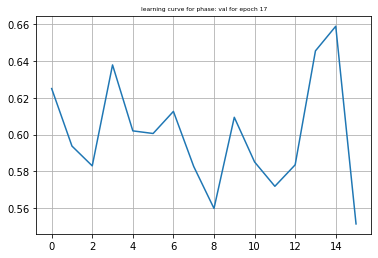

val Loss: 0.6353 f1: 0.8994 precision: 0.8979 recall: 0.9026
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


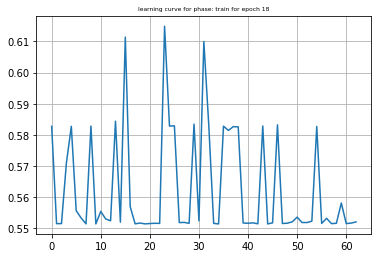

train Loss: 0.6372 f1: 0.9835 precision: 0.9857 recall: 0.9814
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


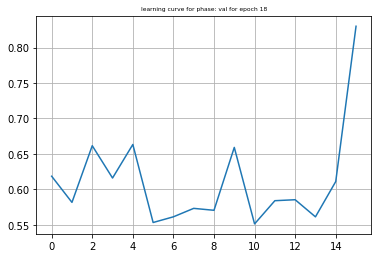

val Loss: 0.6328 f1: 0.9009 precision: 0.8936 recall: 0.9096
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


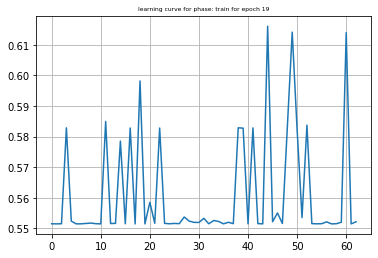

train Loss: 0.6353 f1: 0.9858 precision: 0.9877 recall: 0.9840
####################################################


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


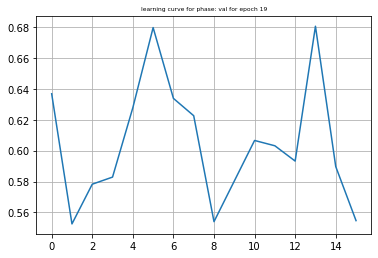

val Loss: 0.6402 f1: 0.8765 precision: 0.8675 recall: 0.8861
####################################################


In [ ]:
model = train_model(model_vgg16, criterion, optimizer, epoch=20)

In [ ]:
plt.plot([i for i in range(10)])
plt.title('sma')
plt.grid(True)

In [ ]:
sam = np.array([[1,2,3], [1,2,3],[1,2,3]])
sam2 = np.array([[1,2,3], [1,2,3],[1,2,3]])

In [ ]:
sam * sam2

array([[1, 4, 9],
       [1, 4, 9],
       [1, 4, 9]])

In [ ]:
augs = [fliped_image, croped_image, contrasted_image, identitied_image, blur_image]